In [38]:
import numpy
import h5py
import pandas

from toposample import Config, data
from figure_helper import FigureHelper
from helper_functions import Percentile, Normalizer
from pandas_helper import column_names_to_values
from toposample.db import get_column_from_database
from toposample.data import read_h5_dataset

"""
Main config file. This file specifies the paths to all the result files and allows us to read the results.
"""
cfg = Config("../working_dir_mn_sz50/config/common_config.json")

"""
Additional parameterization, like which examples to plot and in which color
"""
# Which parameters to plot and in which order. We determined them in the Fig 3 notebook
spec_parameters = ['Transitive clustering coefficient', 'Adjacency spectral gap (low)', 'Relative boundary', 'Fourth density coefficient', 'Normalized Betti coefficient', 'Fifth density coefficient', 'Afferent extension rate', 'Out-degree', 'In-degree', 'Efferent extension rate', 'Euler characteristic']
# Names of other properties of neuron samples that we will analyze (see below)
spec_comm_coupling = ['Community coupling', 'Mean tribe community coupling']
spec_size_related = ['Tribe size', 'Mean size']

fig_4a_bar_params = {"color": "grey"}
fig_4a_plot_params = {"marker": '.', "ms": 1.,
                      "color": 'blue', "ls": 'None'}
fig_4a_err_params = {"ls": 'None', "color": 'black',
                     "elinewidth": 3, "capsize": 5}
fig_4b_ss_params = {"color": [0.75, 0.4, 0.4], "marker": "o",
                    "ms": 4.5, "ls": ":"}
fig_4b_plot_params = {"ls": "None", "marker": "d",
                      "ms": 7, "color": 'grey'}
fig_4b_err_params = {"lw": 0.5, "color": 'black'}
fig_4b_idv_params = {"ls": "None", "marker": '.',
                     "ms": 1, "color": 'blue'}
fig_s3_plot_params = {"marker": '.', "ms": 2,
                      "color": 'blue', "ls": 'None'}
fig_s3_bar_params = {"color": 'grey'}
fig_s3_err_params = {"ls": 'None', "color": 'black',
                     "elinewidth": 3, "capsize": 5}
fig_s4_plot_params = {"marker": '.', "ms": 2,
                      "ls": 'None', "color": 'grey'}
fig_s4_fit_params = {"ls": '--', "color": 'black'}
fig_4d_bar_params = {"color": 'gray', "width": 0.8}
fig_5d_bar_params = {"width": 0.8}
fig_6d_plot_params = {"marker": '.', "ms": 5,
                      "ls": 'None'}
fig_6d_fit_params = {"ls": '--', "color": 'black'}

"""
To save plots in standardized locations, i.e. under ./figures
"""
fhlpr = FigureHelper()
F = fhlpr("Figure 4")
S = fhlpr("Figure S4")
F5 = fhlpr("Figure 5")
F6 = fhlpr("Figure 6")

In [21]:
"""
Files we are going to load
"""
tribe_struc_params_fn = cfg._cfg['analyzed']['struc_parameters']
tribe_triads_fn = cfg._cfg['analyzed']['triads']
tribe_gids_fn = cfg._cfg['analyzed']['tribes']
db_fn = cfg._cfg['analyzed']['database']
tribe_accuracy_fn = cfg._cfg['analyzed']['classifier_components_results']

"""
Load the data
"""
acc_reader = read_h5_dataset("scores")  # Loading function to extract the accuracy

# Values of the topological parameters for all neuron samples
tribe_struc_params = data.TopoData(tribe_struc_params_fn)

#tribe_triads = data.TopoData(tribe_triads_fn)['overexpression'].map(numpy.array)
# The identifiers of neurons in all neuron samples.
# Used to determine sample sizes and mean values of topol. parameters.
tribe_gids = data.TopoData(tribe_gids_fn)['gids']

# The "database" with topological and functional parameters for all neurons in the model
db = pandas.read_pickle(db_fn)

# Finally, the classification accuracies for all neuron samples
data_acc = data.TopoData(tribe_accuracy_fn, follow_link_functions={"data_fn": (acc_reader, True)})['data_fn']

#param_definitions = cfg.stage("struc_tribe_analysis")["config"]["Parameters"]


In [45]:
"""
Some analysis of the data
"""
# The mean accuracy of a sample over the 5-times cross-validation
tribe_nonpooled_mean_acc = data_acc.map(numpy.nanmean)

# All individual accuracies for a given type of sample (e.g. champion of euler characteristic)
tribe_pooled_acc = data_acc.pool(["index"], func=numpy.hstack)
# And the mean value thereof
tribe_mean_acc = tribe_pooled_acc.map(numpy.nanmean)
# As well as the standard deviation
tribe_sd_acc = tribe_pooled_acc.map(numpy.nanstd)

#  We sort the order of topological parameters to use by their accuracy in the manifold task
idxx = numpy.argsort([tribe_mean_acc.get2(sampling="Parameter", specifier=spec)
                      for spec in spec_parameters])
spec_parameters = [spec_parameters[i] for i in idxx]

# The sizes of all neuron samples
tribe_size = tribe_gids.map(len)
# Average for a given type of sample
tribe_mean_size = tribe_size.pool(["index"], func=numpy.mean)
# Add the size of the samples to the data structure holding the other topological and functiona parameters
tribe_struc_params.data["Tribe size"] = tribe_size

# Above, we calculated the size of each neuron sample, tribal or volumetric. Now we go one step further:
# For each sample look up the contained neurons, calculate the sizes of their associated tribes and take the mean.
# I.e. the mean size of tribes whose chief is contained in the sample. This gives a measure of the average
# connectedness of the neuron sample.
all_lengths = db["tribe"].apply(len) # Look up tribe size for _all_ tribes in the db
mean_lengths = tribe_gids.map(lambda x: numpy.mean(all_lengths.loc[x])) # calculate mean size of contained neurons
tribe_struc_params.data["Mean size"] = mean_lengths # And add the result to the data structure

# Similar to the above, we calculate the mean value of the coupling coefficient of contained neurons for all samples
# We already have "Community coupling" in the data structure, which is the coupl. coeff. of only the chief. This is
# the mean of _all_ contained neurons (and also works for volumetric samples, which don't have a chief)
tribe_struc_params.data["Mean tribe community coupling"] =\
tribe_gids.map(lambda x: numpy.nanmean(db["comm_coupling"].loc[x]))

#  Helper function: For a given parameter find all its "subsampled" versions and return them in order
def find_subsampled(base_parameter, data_struc=None):
    if data_struc is None:
        data_struc = data_acc
    subs_specs = data_struc.filter(sampling="subsampled").labels_of("specifier")
    ret_x = []
    ret_specs = []
    for spec in subs_specs:
        spec_name, spec_val = spec.split("@")
        if spec_name != base_parameter:
            continue
        ret_x.append(int(spec_val))
        ret_specs.append(spec)
    idxx = numpy.argsort(ret_x)
    return [ret_x[i] for i in idxx], [ret_specs[i] for i in idxx]


<ipython-input-45-a7a5cf4abd62>:38: RuntimeWarning: Mean of empty slice
  tribe_gids.map(lambda x: numpy.nanmean(db["comm_coupling"].loc[x]))


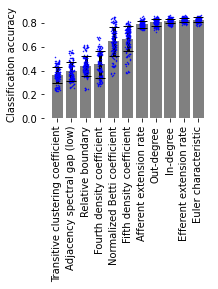

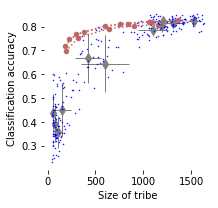

In [4]:
"""
Figure panel: Accuracies for the champions of the various parameters
"""
from matplotlib import pyplot as plt

plot_mean_acc = [tribe_mean_acc.get2(sampling="Parameter", specifier=spec)
                for spec in spec_parameters]
plot_sd_acc = [tribe_sd_acc.get2(sampling="Parameter", specifier=spec)
               for spec in spec_parameters]

fig = plt.figure(figsize=(3, 2))
ax = fig.gca()

ax.bar(range(len(plot_mean_acc)), plot_mean_acc, **fig_4a_bar_params)
for x, spec in enumerate(spec_parameters):
    y = tribe_pooled_acc.get2(sampling="Parameter", specifier=spec)
    ax.plot(x + 0.35 * (numpy.random.rand(len(y)) - 0.5), y, **fig_4a_plot_params)
ax.errorbar(range(len(plot_mean_acc)), plot_mean_acc, yerr=plot_sd_acc, **fig_4a_err_params)
ax.set_xticks(range(len(spec_parameters)))
_ = ax.set_xticklabels(spec_parameters, rotation='vertical')
ax.set_ylabel("Classification accuracy")
plt.box(False)
F.save(fig, fn="Panel-A")

"""
Figure panel: Accuracies vs. sizes of the tribes
"""
fig = plt.figure(figsize=(3, 3))
ax = fig.gca()

for spec in spec_parameters:
    index, x = tribe_size.get_x_y("index", sampling="Parameter", specifier=spec)
    mean_x = tribe_mean_size.get2(sampling="Parameter", specifier=spec)
    y = [tribe_nonpooled_mean_acc.get2(sampling="Parameter", specifier=spec, index=idx) for idx in index]
    mean_y = tribe_mean_acc.get2(sampling="Parameter", specifier=spec)
    
    _, subs_spec = find_subsampled(spec)
    if len(subs_spec):
        subs_x = [tribe_mean_size.get2(sampling="subsampled", specifier=_spec) for _spec in subs_spec]
        subs_y = [tribe_mean_acc.get2(sampling="subsampled", specifier=_spec) for _spec in subs_spec]
        ax.plot(subs_x + [mean_x], subs_y + [mean_y], **fig_4b_ss_params)

    ax.plot(mean_x, mean_y, **fig_4b_plot_params)
    ax.errorbar(mean_x, mean_y, xerr=numpy.std(x), yerr=numpy.std(y), **fig_4b_err_params)
    ax.plot(x, y, **fig_4b_idv_params)
    ax.set_xlabel("Size of tribe")
    ax.set_ylabel("Classification accuracy")
plt.box(False)
F.save(fig, fn="Panel-B")

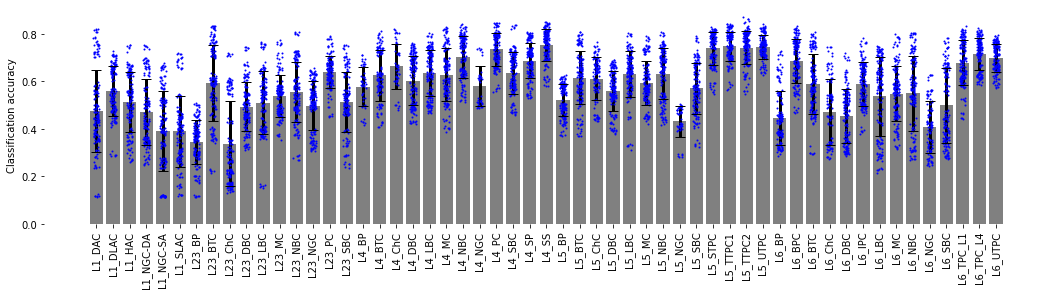

In [6]:
"""
Figure panel: Accuracies for the randomly sampled tribes
"""
# Names of the randomly picked morphological types.
mtype_names = tribe_mean_acc.filter(sampling="M-type").labels_of("specifier")
# Look up mean and sd accuracies for those samples.
plot_mean_acc = [tribe_mean_acc.get2(sampling="M-type", specifier=spec)
                for spec in mtype_names]
plot_sd_acc = [tribe_sd_acc.get2(sampling="M-type", specifier=spec)
               for spec in mtype_names]

fig = plt.figure(figsize=(18, 4))
ax = fig.gca()

ax.bar(range(len(plot_mean_acc)), plot_mean_acc, **fig_s3_bar_params)
for x, spec in enumerate(mtype_names):
    y = tribe_pooled_acc.get2(sampling="M-type", specifier=spec)
    ax.plot(x + 0.35 * (numpy.random.rand(len(y)) - 0.5), y, **fig_s3_plot_params)
ax.errorbar(range(len(plot_mean_acc)), plot_mean_acc, yerr=plot_sd_acc, **fig_s3_err_params)
    
ax.set_xticks(range(len(mtype_names)))
_ = ax.set_xticklabels(mtype_names, rotation='vertical')
ax.set_ylabel("Classification accuracy")
plt.box(False)

S.save(fig, fn="Panel-A")

In [46]:
from pandas_helper import assemble_result_dataframe, sanitize_param_name
from statsmodels.formula.api import ols
from scipy.stats import pearsonr

"""
We do some more analysis here. Some of the functions we use require data in the form a pandas.Dataframes.
We have a helper function that assembles the data accordingly. Let's build those dataframes!
"""

mtypes_l1_l5 = ['L1_DAC', 'L1_DLAC', 'L1_HAC', 'L1_NGC-DA', 'L1_NGC-SA', 'L1_SLAC', 'L23_BP', 'L23_BTC',
                   'L23_ChC', 'L23_DBC', 'L23_LBC', 'L23_MC', 'L23_NBC', 'L23_NGC', 'L23_PC', 'L23_SBC',
                   'L4_BP', 'L4_BTC', 'L4_ChC', 'L4_DBC', 'L4_LBC', 'L4_MC', 'L4_NBC', 'L4_NGC', 'L4_PC',
                   'L4_SBC', 'L4_SP', 'L4_SS', 'L5_BP', 'L5_BTC', 'L5_ChC', 'L5_DBC', 'L5_LBC', 'L5_MC',
                   'L5_NBC', 'L5_NGC', 'L5_SBC', 'L5_STPC', 'L5_TTPC1', 'L5_TTPC2', 'L5_UTPC']
mtypes_l6 = ['L6_BP', 'L6_BPC', 'L6_BTC', 'L6_ChC', 'L6_DBC', 'L6_IPC', 'L6_LBC', 'L6_MC', 'L6_NBC',
             'L6_NGC', 'L6_SBC', 'L6_TPC_L1', 'L6_TPC_L4', 'L6_UTPC']

# Accuracies, topological parameters and tribe-size related data for the randomly picked tribes
dframe_random_tribes =\
assemble_result_dataframe(tribe_nonpooled_mean_acc, # Accuracy data
                          tribe_struc_params, # Structural and coupling-related data
                          sampling="M-type", # Which type of sample to look up
                          parameters_to_add=spec_parameters + spec_size_related # Which parameters to add
                         )
# Accuracies, and tribe-size related data for "champion" samples
dframe_champions =\
assemble_result_dataframe(tribe_nonpooled_mean_acc, tribe_struc_params, sampling="Parameter",
                          parameters_to_add=spec_size_related
                         )
# Accuracies, coupling-related and tribe-size-related data for randomly picked tribes in L1-5
dframe_tribes_coupl_l1l5 =\
assemble_result_dataframe(tribe_nonpooled_mean_acc, tribe_struc_params, sampling="M-type",
                          labels_to_iterate=mtypes_l1_l5, # Which specific samples (mtypes) to look up
                          parameters_to_add=spec_comm_coupling + spec_size_related
                         )
# Accuracies, coupling-related and tribe-size-related data for randomly picked tribes in L6
dframe_tribes_coupl_l6 =\
assemble_result_dataframe(tribe_nonpooled_mean_acc, tribe_struc_params, sampling="M-type",
                          labels_to_iterate=mtypes_l6,
                          parameters_to_add=spec_comm_coupling + spec_size_related
                         )
# Accuracies, topological parameters, tribes-size and coupling-related data for volumetric samples
dframe_vol_coupl =\
assemble_result_dataframe(tribe_nonpooled_mean_acc, tribe_struc_params, sampling="Radius",
                          parameters_to_add=spec_parameters + spec_comm_coupling + spec_size_related
                         )

# To provide an example of what we got from this
display(dframe_random_tribes.head())

"""
Now analyze. First, we fit a linear fit of mean tribe size against accuracy using the random samples.
(Note: below we plot one against the other to show that linear fit makes sense. Also see the p-value)
"""
model_size = ols("Accuracy ~ Mean_size", data=dframe_random_tribes).fit()
print(model_size.pvalues["Mean_size"])

"""
Add the residuals to the dataframes. For the dataframe we fit the model on we can directly look it up.
For the volumetric data, we instead subtract the prediction
"""
dframe_random_tribes["Accuracy_residual"] = model_size.resid.values
dframe_vol_coupl["Accuracy_residual"] = dframe_vol_coupl["Accuracy"] -\
                                        model_size.predict(dframe_vol_coupl)

"""
Analyze linear dependence of the residual accuray on the various topological parameters. To do that,
we define a function
"""
def analyze_residual_accuracy(dframe, columns, label_residual="Accuracy_residual"):
    res_out = {}
    for col in columns:
        model = ols("{0} ~ {1}".format(label_residual, sanitize_param_name(col)), data=dframe).fit()
        correlation = pearsonr(dframe[sanitize_param_name(col)], dframe[label_residual])
        res_out[col] = {"model": model, "corr": correlation}
    return res_out

residual_data_tribes = analyze_residual_accuracy(dframe_random_tribes, spec_parameters)
residual_data_vol = analyze_residual_accuracy(dframe_vol_coupl, spec_parameters + spec_comm_coupling)

,specifier,Accuracy,Transitive_clustering_coefficient,Adjacency_spectral_gap_low,Relative_boundary,Fourth_density_coefficient,Normalized_Betti_coefficient,Fifth_density_coefficient,Afferent_extension_rate,Outdegree,Indegree,Efferent_extension_rate,Euler_characteristic,Tribe_size,Mean_size
0,L23_MC,0.645717,0.0295,0.0001,26.3750,4.314920e-07,0.0766,0.0,22766.0,668.0,57.0,25968.0,467.0,719,591.787204
1,L23_MC,0.549592,0.0288,0.0001,25.6221,4.814953e-07,0.2113,0.0,21366.0,603.0,155.0,25685.0,893.0,741,531.751687
2,L23_MC,0.425473,0.0455,0.0004,62.4744,0.000000e+00,0.1615,0.0,13213.0,123.0,53.0,15935.0,13.0,174,485.810345
3,L23_MC,0.477290,0.0382,0.0001,61.6815,0.000000e+00,0.1125,0.0,13552.0,137.0,54.0,16474.0,26.0,192,455.869792
4,L23_MC,0.508435,0.0349,0.0011,54.0406,6.647310e-07,0.1202,0.0,18842.0,243.0,75.0,23415.0,13.0,318,578.248428


7.596047276296033e-142


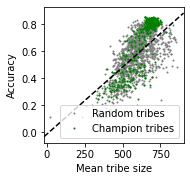

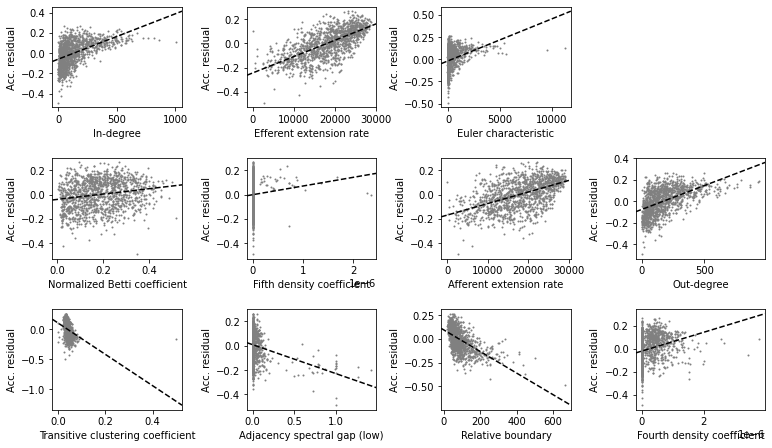

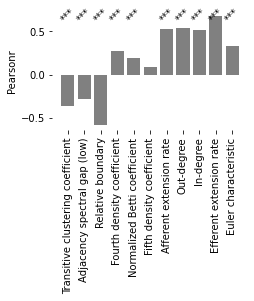

In [49]:
"""
Figure panel: Mean tribe size against accuracy for the "random" tribes and "champions"
"""

fig = plt.figure(figsize=(2.5, 2.5))
ax = fig.gca()
ax.plot(dframe_random_tribes["Mean_size"], dframe_random_tribes["Accuracy"],
        label="Random tribes", **fig_s4_plot_params)
tmp_plot_params = fig_s4_plot_params.copy(); tmp_plot_params["color"] = "green"
ax.plot(dframe_champions["Mean_size"], dframe_champions["Accuracy"],
        label="Champion tribes", **tmp_plot_params)
xx = ax.get_xlim()
ax.set_xlim(xx)
ax.plot(xx, model_size.params["Intercept"] + model_size.params["Mean_size"] * numpy.array(xx),
        **fig_s4_fit_params)
ax.set_xlabel("Mean tribe size")
ax.set_ylabel("Accuracy")
plt.legend()
S.save(fig, fn="Panel-B")

"""
Figure panel: Various topol. parameters agains residual accuracy
"""
residual_data_tribes = analyze_residual_accuracy(dframe_random_tribes, spec_parameters)
fig = plt.figure(figsize=(12, 7))
N = len(residual_data_tribes)
X = 4
i = 0
for col, residual_result in residual_data_tribes.items():
    model = residual_result["model"]
    col_san = sanitize_param_name(col)
    
    pos_x = numpy.mod(i, X); pos_y = numpy.floor(i / X)
    i += 1
    
    ax = fig.add_axes([0.05 + pos_x * 0.225, 0.05 + pos_y * 0.3, 0.15, 0.2])
    ax.plot(dframe_random_tribes[col_san],
            dframe_random_tribes["Accuracy_residual"], **fig_s4_plot_params)
    
    xx = ax.get_xlim(); ax.set_xlim(xx)
    ax.plot(xx, model.params["Intercept"] + model.params[col_san] * numpy.array(xx), **fig_s4_fit_params)
    ax.set_xlabel(col)
    ax.set_ylabel("Acc. residual")

S.save(fig, fn="Panel-C")

"""
Figure panel: pearsonr values of the fits for the various parameters
"""
plot_labels = residual_data_tribes.keys()
plot_r = [residual_data_tribes[k]["corr"][0] for k in plot_labels]
adjusted_threshs = numpy.array([1E-3, 1E-4, 1E-5]) / len(residual_data_tribes)
plot_is_sig = [numpy.sum(residual_data_tribes[k]["corr"][1] < adjusted_threshs)
               for k in plot_labels]

fig = plt.figure(figsize=(3.5, 2.2));
ax = fig.gca()
ax.bar(numpy.arange(len(plot_labels)),
       plot_r, **fig_4d_bar_params)
for i, is_sig in enumerate(plot_is_sig):
    if is_sig > 0:
        ax.text(i, 0.6, "*" * is_sig, color="black", horizontalalignment="center", rotation=45)
ax.set_xticks(range(len(plot_labels)))
_ = ax.set_xticklabels(plot_labels, rotation='vertical')
ax.set_ylabel("Pearsonr")
plt.box(False)
F.save(fig, fn="Panel-C")

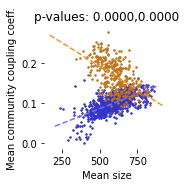

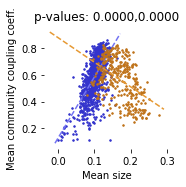

In [28]:
"""
Figure panels: Coupling coefficients against mean tribe size and accuracies for the "random" samples; 
separately for random samples where the chief is in L1-L5 and where the chief is in L6
"""

def plot_function(fit_plt_x, fit_plt_y, xlabel, ylabel):
    ax = plt.figure(figsize=(2.25, 2.25)).gca()
    ax.plot(dframe_tribes_coupl_l1l5[fit_plt_x],
            dframe_tribes_coupl_l1l5[fit_plt_y], '.', ms=3, color=[0.2, 0.2, 0.8])
    model = ols("{0} ~ {1}".format(fit_plt_y, fit_plt_x), data=dframe_tribes_coupl_l1l5).fit()
    ax.plot(ax.get_xlim(), model.params["Intercept"] +
            model.params[fit_plt_x] * numpy.array(ax.get_xlim()),
           ls='--', color=[0.45, 0.45, 0.95])

    ax.plot(dframe_tribes_coupl_l6[fit_plt_x],
            dframe_tribes_coupl_l6[fit_plt_y], '.', ms=3, color=[0.75, 0.45, 0.1])
    model_l6 = ols("{0} ~ {1}".format(fit_plt_y, fit_plt_x), data=dframe_tribes_coupl_l6).fit()
    ax.plot(ax.get_xlim(), model_l6.params["Intercept"] +
            model_l6.params[fit_plt_x] * numpy.array(ax.get_xlim()),
           ls='--', color=[0.9, 0.6, 0.2])

    ax.set_title("p-values: {0:5.4f},{1:5.4f}".format(model.pvalues[fit_plt_x],
                                           model_l6.pvalues[fit_plt_x]))
    ax.set_xlabel("Mean size")
    ax.set_ylabel("Mean coupling coeff.")
    plt.box(False)

plot_function("Mean_size", "Mean_tribe_community_coupling", 
              "Mean size", "Mean coupling coeff.")
F6.save(plt.gcf(), fn="Panel-A")
plot_function("Mean_tribe_community_coupling", "Accuracy", 
              "Mean coupling coeff.", "Accuracy")
F6.save(plt.gcf(), fn="Panel-B")


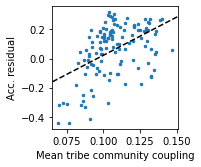

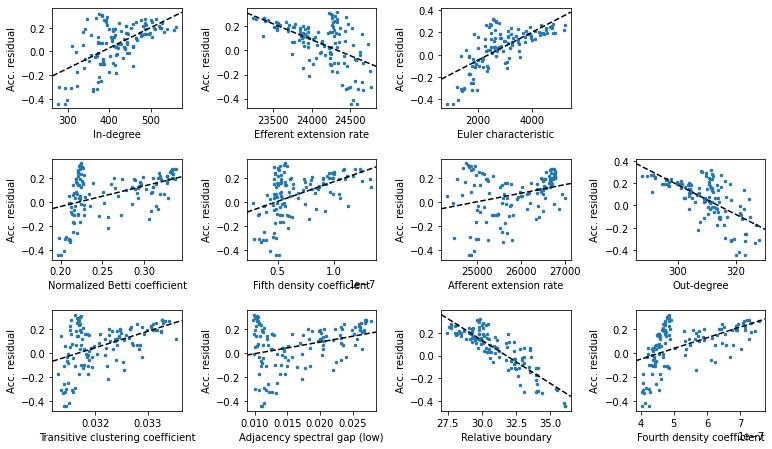

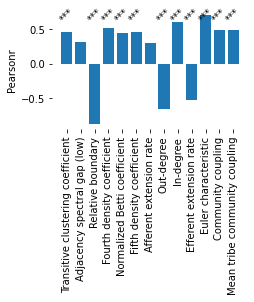

In [40]:
fig = plt.figure(figsize=(2.25, 2.25))
ax = fig.gca()

"""
Figure panel: Mean coupling coeff. in volumetric samples against their accuracy residual
"""
col = "Mean tribe community coupling"
residual_result = residual_data_vol[col]
model = residual_result["model"]
col_san = sanitize_param_name(col)

ax.plot(dframe_vol_coupl[col_san],
        dframe_vol_coupl["Accuracy_residual"], **fig_6d_plot_params)

xx = ax.get_xlim(); ax.set_xlim(xx)
ax.plot(xx, model.params["Intercept"] + model.params[col_san] * numpy.array(xx), **fig_6d_fit_params)
ax.set_xlabel(col)
ax.set_ylabel("Acc. residual")

F6.save(fig, fn="Panel-D")

"""
Figure panel: Synthetic values of topological parameters of vol. samples vs accuracy residuals
"""
fig = plt.figure(figsize=(12, 7))

N = len(spec_parameters)
X = 4
i = 0
for col in spec_parameters:
    residual_result = residual_data_vol[col]
    model = residual_result["model"]
    col_san = sanitize_param_name(col)
    
    pos_x = numpy.mod(i, X); pos_y = numpy.floor(i / X)
    i += 1
    
    ax = fig.add_axes([0.05 + pos_x * 0.225, 0.05 + pos_y * 0.3, 0.15, 0.2])
    ax.plot(dframe_vol_coupl[col_san],
            dframe_vol_coupl["Accuracy_residual"], **fig_6d_plot_params)
    
    xx = ax.get_xlim(); ax.set_xlim(xx)
    ax.plot(xx, model.params["Intercept"] + model.params[col_san] * numpy.array(xx), **fig_6d_fit_params)
    ax.set_xlabel(col)
    ax.set_ylabel("Acc. residual")

S.save(fig, fn="Panel-figS5")

"""
Figure panel: pearsonr values of the fits for the various parameters
"""
plot_labels = residual_data_vol.keys()
plot_r = [residual_data_vol[k]["corr"][0] for k in plot_labels]
adjusted_threshs = numpy.array([1E-3, 1E-4, 1E-5]) / len(residual_data_tribes)
plot_is_sig = [numpy.sum(residual_data_vol[k]["corr"][1] < adjusted_threshs)
               for k in plot_labels]

fig = plt.figure(figsize=(3.5, 2.2));
ax = fig.gca()
ax.bar(numpy.arange(len(plot_labels)),
       plot_r, **fig_5d_bar_params)
for i, is_sig in enumerate(plot_is_sig):
    if is_sig > 0:
        ax.text(i, 0.6, "*" * is_sig, color="black", horizontalalignment="center", rotation=45)
ax.set_xticks(range(len(plot_labels)))
_ = ax.set_xticklabels(plot_labels, rotation='vertical')
ax.set_ylabel("Pearsonr")
plt.box(False)

F5.save(fig, fn="Panel-D")